In [1]:
from forecast.core import DataGenerator, make_photoz_bin_edges, compare_fisher_matrices
from lumin_functions.core import def_agn_xlf
%matplotlib inline


fiducial_params = {'Omega_c': 0.25, 'Omega_b': 0.05,
                   'h': 0.7, 'sigma8': 0.8, 'n_s': 0.96,
                   'transfer_function': 'boltzmann_camb',
                   'baryons_power_spectrum': 'nobaryons',
                   'matter_power_spectrum': 'linear'}

fsky = 0.658
powspec_pars_dict_agn = {
    'slim': 1e-14,
    'sigma_0': 0.03,
    'f_fail': 0.1,
    'l_min': 10,
    'l_max': 500,
    'log_bins': 41,
    'fsky': fsky,
    'has_rsd': True,
    'use_weighed_bias': False,
    'density_multiplier': 1.3,
    'camb_llimber': 110,
    'xlf': def_agn_xlf,
    'use_camb': True,
    'delta_i': 3,
    'remove_ignored_cells': True,
}


SETNAME = 'AGN_optimistic_h_ns_prior'

zmin_agn = 0.5
zmax_agn = 2.5
k_photoz_agn = 1


bin_left_edges = make_photoz_bin_edges(
    zmin_agn, zmax_agn, k=k_photoz_agn, sigma_0=powspec_pars_dict_agn['sigma_0'])
powspec_pars_dict_agn['bin_left_edges'] = bin_left_edges


set palette to mallsoft, shuffle=False
set matplotlib rc


In [2]:
datagen = DataGenerator(
                        fiducial_params=fiducial_params, set_name=SETNAME,)

datagen.invoke(
    **powspec_pars_dict_agn, plot_cell=False, plot_dndz=False)


dNdz calculating: 100%|██████████| 751/751 [00:02<00:00, 251.58it/s]


Total AGN sources: 1914915 at fsky=0.658[27144 deg^2]
Photo-z parameters: self.sigma_0=0.03, self.f_fail=0.1
calculating CAMB...
CAMB calculation time: 2.7867510318756104


calc Covariance: 100%|██████████| 435/435 [00:01<00:00, 254.34it/s]


In [4]:
model_fiducial = get_model(
        f'info_auto.yaml')  # type: ignore

point = dict(zip(model_fiducial.parameterization.sampled_params(),
                 model_fiducial.prior.sample(ignore_external=True)[0]))

point.update({'Omega_c': 0.25, 'Omega_b': 0.05, 'h': 0.7, 'n_s': 0.96, 'sigma8': 0.8})

logposterior = model_fiducial.logposterior(point)
print('Full log-posterior:')
print('   logposterior:', logposterior.logpost)
print('   loglikelihoods:', logposterior.loglikes)

cls_cobaya = model_fiducial.provider.get_result('Cell_data_lkl')
cov_cobaya = model_fiducial.provider.get_result('Cell_cov_lkl')
icov_cobaya = model_fiducial.provider.get_result('Cell_inv_cov_lkl')


[model] *WARNING* Ignored blocks/options: ['sampler', 'output']


/Users/sdbykov/work/clustering_forecast/forecast/cobaya_classes.py:79: UserWarning: Using standard cosmological parameters: 0.25, 0.05, 0.7, 0.96,  0.8
  warnings.warn(
dNdz calculating: 100%|██████████| 751/751 [00:03<00:00, 246.88it/s]


Total AGN sources: 1914915 at fsky=0.658[27144 deg^2]
Photo-z parameters: self.sigma_0=0.03, self.f_fail=0.1
calculating CAMB...
CAMB calculation time: 2.7572710514068604


calc Covariance: 100%|██████████| 435/435 [00:01<00:00, 250.43it/s]


Full log-posterior:
   logposterior: 8.109771381912552
   loglikelihoods: [-0.]


In [5]:

assert np.allclose(datagen.cls_rebin_lkl, cls_cobaya, atol=0,
                       rtol=1e-6), datagen.cls_rebin_lkl/cls_cobaya

assert np.allclose(cov_cobaya, datagen.cov_rebin_lkl, atol = 0, rtol = 1e-5), cov_cobaya/datagen.cov_rebin_lkl

#assert np.allclose(icov_cobaya+1, datagen.inv_cov_rebin_lkl+1, atol = 0, rtol = 1e-5), icov_cobaya/datagen.inv_cov_rebin_lkl

#assert np.allclose(-np.linalg.slogdet(datagen.cov_rebin_lkl)[1]/2, logposterior.loglikes, atol = 0, rtol = 1e-3)

In [8]:
pars_check = [0.239893, 0.034480146, 0.66266388, 0.96441286, 0.78960095]
#pars_check = [0.25, 0.05, 0.70068496, 0.96, 0.8]
point.update({'Omega_c': pars_check[0], 'Omega_b': pars_check[1], 'h': pars_check[2], 'n_s': pars_check[3], 'sigma8': pars_check[4]})

logposterior = model_fiducial.logposterior(point)
print('Full log-posterior:')
print('   logposterior:', logposterior.logpost)
print('   loglikelihoods:', logposterior.loglikes)
cls_cobaya = model_fiducial.provider.get_result('Cell_data_lkl')
cls_datagen = datagen.Cell_mean(pars_check)[1]


assert np.allclose(cls_datagen, cls_cobaya, atol=0,
                       rtol=1e-6), cls_datagen/cls_cobaya



Full log-posterior:
   logposterior: 0.5416593389381408
   loglikelihoods: [-7.1919482]


(0.0, 300.0)

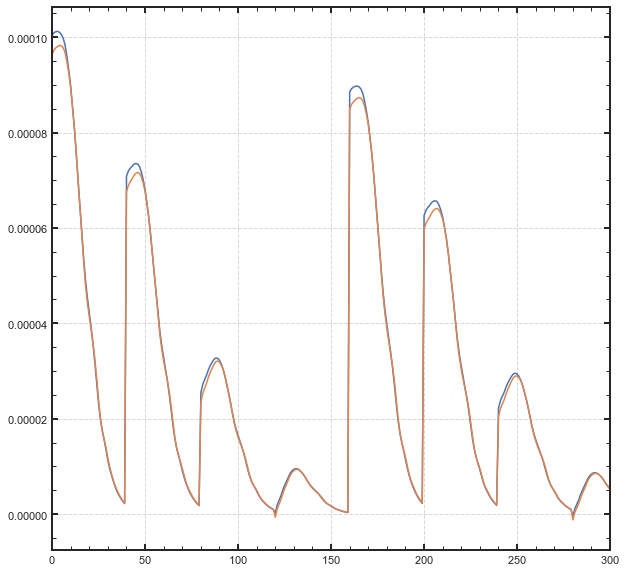

In [9]:
plt.figure(figsize=(10,10))
plt.plot(cls_cobaya)
plt.plot(datagen.cls_rebin_lkl)
plt.xlim(0,300)

In [14]:
gaussian_loglike(cls_cobaya, datagen.cls_rebin_lkl, datagen.cov_rebin_lkl, include_logdet=False)

-7.191948261371909

In [17]:
logposterior.logpriors+gaussian_loglike(cls_cobaya, datagen.cls_rebin_lkl, datagen.cov_rebin_lkl, include_logdet=False)

array([0.05760998])

In [12]:

if fix_cov:
    assert np.allclose(model_fiducial.provider.get_result('Cell_cov_lkl'), datagen.cov_rebin_lkl, atol = 0, rtol = 1e-5), cov_cobaya/datagen.cov_rebin_lkl

NameError: name 'fix_cov' is not defined

In [10]:
if fix_cov:
    assert np.allclose(logposterior.loglikes[0], gaussian_loglike(cls_datagen, datagen.cls_rebin_lkl, datagen.cov_rebin_lkl, include_logdet=not fix_cov), atol = 0, rtol = 1e-3)

In [11]:
print(logposterior.loglikes[0], gaussian_loglike(cls_datagen, datagen.cls_rebin_lkl, datagen.cov_rebin_lkl, include_logdet=not fix_cov))

-648.4754910026182 -648.475494623499


In [12]:
gaussian_loglike(cls_datagen, datagen.cls_rebin_lkl, datagen.cov_rebin_lkl, include_logdet=False)

-648.475494623499